In [44]:
import numpy as np
from scipy import stats
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression 


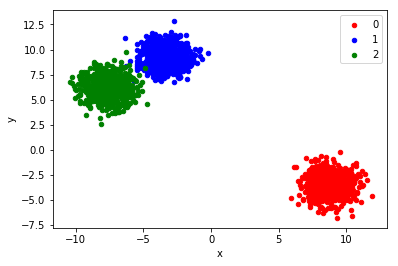

(2000, 3)
(2000, 5)
(2000,)


In [45]:
"""
This algorithm is designed deal with the weighted likelihood function mentioned in the paper "LOCAL UNCERTAINTY SAMPLING FOR LARGE-SCALE
MULTI-CLASS LOGISTIC REGRESSION", the input matrix A is the weight matrix, which is returned by other learning algorithms. In order 
to simulate the unweighted version, just set A = np.ones([n, K]), as what I do below
"""
#Generate some test data
n=2000
K=3
d=5
X, y = make_blobs(n_samples=n, centers=K, n_features=d)
gamma=2
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()
#set A = np.ones([n, K]) to simulate unweighted version
A = np.ones([n, K])
print(A.shape)
print(np.shape(X))
print(np.shape(y))

In [46]:
"""
Input to the logistic regression:
X (n, d) the training data, n is the number of data and d is number of features
y (n) the training label, varies from 0 to K-1 where K is number of classes
K scalar, number of classes
A (n, K) the weight matrix
learning rate lr
learning rate decay decay, default setting is 1
number of iterations num_iter

"""

def initialize_W_b(X, K):
    """
    X is n*d
    K is number of classes
    return W is K-1*d
    return b is K-1
    """
    n, d = np.shape(X)
    W = np.random.rand(K-1, d)
    b = np.random.rand(K-1)
    return W, b
    
    
def likelihood(X, y, W, b, A):
    """
    A n*K
    return the log likelihood
    """
    n, d= np.shape(X)
    n, K=np.shape(A)
    
    #应该用 X*W.T 得到n*(K-1)的f(X)矩阵
    f_X = np.dot(X, W.T) + b
    #first K-1 columns of A
    A_first = A[ : ,0:K-1 ]
    e_f = np.exp(f_X)
    denumerator = e_f * A_first#n*K-1
    denumerator = 1+ np.sum(denumerator, axis = 1)*(1/A[ : , K-1])#/a(xi,K),这一步后得到的形状是(n, )
    Indicator_matrix = np.zeros([n, K-1])#n*K-1
    for i in range(0, n):
        if y[i]!=K-1:
            Indicator_matrix[i, y[i]] = 1
    part1=Indicator_matrix*f_X#n*K-1
    part2=np.log(denumerator)#n
    ll=(np.sum(part1)-np.sum(part2))/n
    return ll
    
    
def getGradient(X, y, A, W, b):
    """
    return the gradient GradW K-1*d, Gradb K-1
    
    """
    n, d= np.shape(X)
    n, K=np.shape(A)
    GradW = np.zeros([K-1, d])
    Gradb = np.zeros(K-1)
    
    #first K-1 columns of A
    A_first = A[ : ,0:K-1 ]
    f_X = np.dot(X, W.T) + b
    e_f = np.exp(f_X)
    denumerator = e_f * A_first#n*K-1
    denumerator = 1+ np.sum(denumerator, axis = 1)*(1/A[ : , K-1])#/a(xi,K),这一步后得到的形状是(n, )
    for j in range(0, K-1):
        Indicator = np.zeros(n)
        Indicator[y==j] = 1
        gradw = np.dot(Indicator, X)
        temp = e_f[ : , j]*A[ : , j]/(A[ : , K-1]*denumerator)
        gradw = gradw - np.dot(temp, X)
        gradw = gradw/n
        GradW[ j , : ] = gradw
        gradb = sum(Indicator)-np.sum(temp)
        Gradb[j] = gradb/n
    
    return GradW, Gradb
    
def multi_class_logistic_regression(X, y, K, A, lr, decay, num_iter):
    """
    Main function, return W and b which are the learned parameters
    Also return the history of log likelihoods as hist
    
    """
    W, b = initialize_W_b(X, K)
    hist = np.zeros(num_iter)#record the history of log likelihood
    for i in range(0, num_iter):
        #print("iteration %", i)
        ll = likelihood(X, y, W, b, A)
        hist[i]=ll
        gradW, gradb = getGradient(X, y, A, W, b)
        b = b + lr*gradb*decay**(i)
        W = W + lr*gradW*decay**(i)
    
    return W, b, hist



def predict(X, W, b):
    """
    Predict function, return a vector y n*1
    """
    n, d= np.shape(X)
    K, d = np.shape(W)
    y_pred = np.zeros(n)
    f_X = np.dot(X, W.T) + b
    e_f = np.exp(f_X)
    Prob = np.hstack((e_f, np.ones((n,1))))
    y_pred = np.argmax(Prob, axis = 1)
    return y_pred

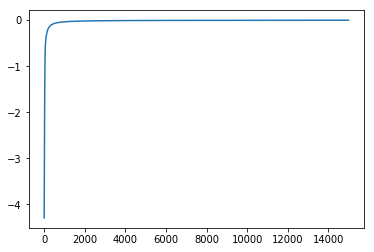

In [47]:
W, b, hist=multi_class_logistic_regression(X, y, K, A, 1e-3, 1, num_iter=15000)
plt.plot(hist)

In [49]:
y_pred = predict(X,W,b)
print("test accuracy is",sum((y_pred!=y)/n))

test accuracy is 0.0
